# HEALTH INSURANCE CROSS SELL PREDICTION

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.


An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.


For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.


Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to the insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

## BUSINESS GOALS

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

### DATA DESCRIPTION

<b>id:</b> Unique ID for the customer

<b>Gender:</b> Gender of the customer

<b>Age:</b> Age of the customer

<b>Driving_License 0:</b> Customer does not have DL, 1 : Customer already has DL

<b>Region_Code:</b> Unique code for the region of the customer

<b>Previously_Insured 1:</b> Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

<b>Vehicle_Age:</b> Age of the Vehicle

<b>Vehicle_Damage 1:</b> Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

<b>Annual_Premium:</b> The amount customer needs to pay as premium in the year

<b>PolicySalesChannel:</b> Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

<b>Vintage:</b> Number of Days, Customer has been associated with the company

<b>Response 1:</b> Customer is interested, 0 : Customer is not interested

### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')

D:\PYTHON310\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: p is an invalid version and will not be supported in a future release
  warnings.warn(


### IMPORT DATASETS

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [5]:
train.shape

(381109, 12)

In [6]:
test.shape

(127037, 11)

#### CHECK FOR MISSING VALUES

In [7]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

- As we can see there's no missing values in our dataset, so we can move onto EDA part of project.

In [8]:
train.drop("id",axis =1).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,0.00,0.05,0.50,0.95,0.99,1.00
Age,20.0,21.0,36.0,69.0,77.0,85.0
Driving_License,0.0,1.0,1.0,1.0,1.0,1.0
Region_Code,0.0,5.0,28.0,47.0,50.0,52.0
Previously_Insured,0.0,0.0,0.0,1.0,1.0,1.0
Annual_Premium,2630.0,2630.0,31669.0,55176.0,72963.0,540165.0
Policy_Sales_Channel,1.0,26.0,133.0,160.0,160.0,163.0
Vintage,10.0,24.0,154.0,285.0,297.0,299.0
Response,0.0,0.0,0.0,1.0,1.0,1.0


## EXPLORATORY DATA ANALYSIS

### CHECK COLUMNS (CATEGORICAL OR NUMERICAL)

In [9]:
def col_names(dataframe, cat_th=10, car_th=20):
    """
    This function is used to return the names of categorical, numerical as well as categorical but cardinal variables in the dataset. 
    
    Parameters
    ------
        dataframe: dataframe
        cat_th: int, optional
                the class threshold for numeric but categorical variables
        car_th: int, optinal
                the class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical Variables List
        num_cols: list
                Numeric Variables List
        cat_but_car: list
                Categorical but cardinal variables list

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is in cat_cols

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = col_names(train)

Observations: 381109
Variables: 12
cat_cols: 6
num_cols: 6
cat_but_car: 0
num_but_cat: 3


In [10]:
cat_cols

['Gender',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Driving_License',
 'Previously_Insured',
 'Response']

In [11]:
num_cols = [col for col in num_cols if "id" not in col]
num_cols = [col for col in num_cols if "Policy_Sales_Channel" not in col]

### SUMMARY CATEGORICAL COLUMNS

        Gender     Ratio
Male    206089  54.07613
Female  175020  45.92387


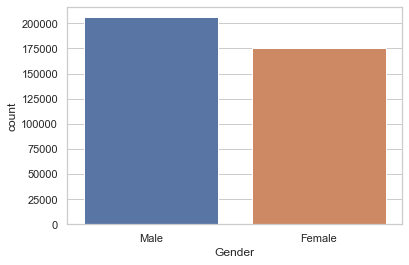

           Vehicle_Age      Ratio
1-2 Year        200316  52.561341
< 1 Year        164786  43.238549
> 2 Years        16007   4.200111


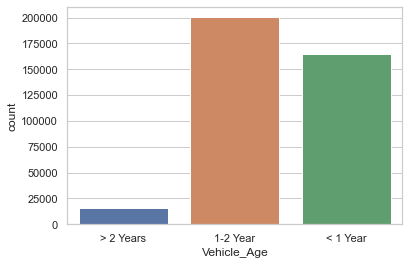

     Vehicle_Damage      Ratio
Yes          192413  50.487656
No           188696  49.512344


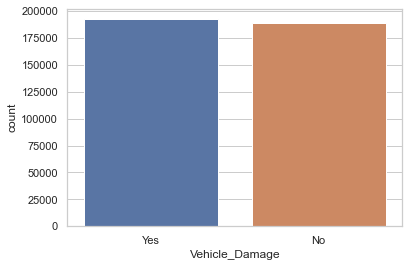

   Driving_License      Ratio
1           380297  99.786938
0              812   0.213062


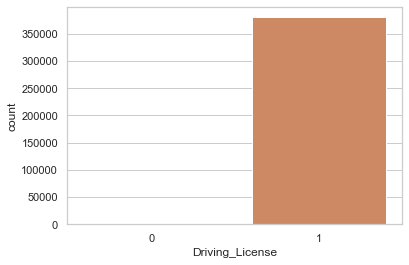

   Previously_Insured      Ratio
0              206481  54.178988
1              174628  45.821012


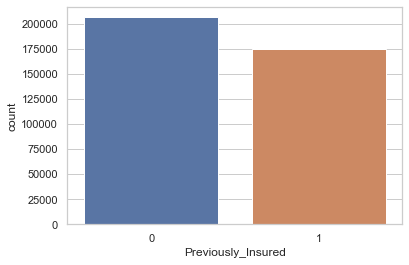

   Response      Ratio
0    334399  87.743664
1     46710  12.256336


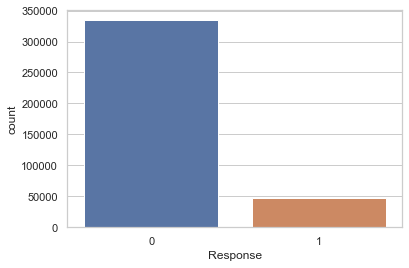

In [12]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for i in cat_cols:
    cat_summary(train, i, plot=True)

### SUMMARY NUMERIC COLUMNS

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
5%           21.000000
10%          22.000000
20%          24.000000
30%          25.000000
40%          29.000000
50%          36.000000
60%          42.000000
70%          47.000000
80%          53.000000
90%          62.000000
95%          69.000000
99%          77.000000
max          85.000000
Name: Age, dtype: float64


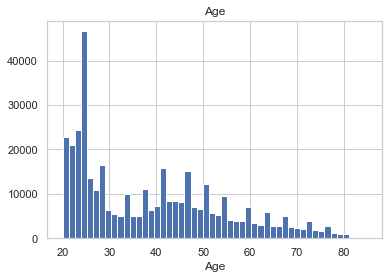

_____________________________________
count    381109.000000
mean         26.388807
std          13.229888
min           0.000000
5%            5.000000
10%           8.000000
20%          11.000000
30%          18.000000
40%          28.000000
50%          28.000000
60%          28.000000
70%          31.000000
80%          39.000000
90%          46.000000
95%          47.000000
99%          50.000000
max          52.000000
Name: Region_Code, dtype: float64


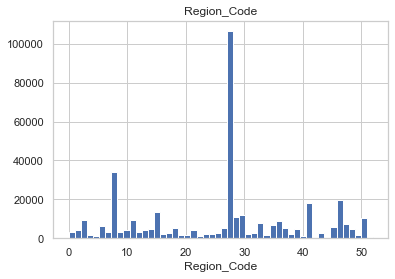

_____________________________________
count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
5%         2630.000000
10%        2630.000000
20%       21583.600000
30%       26238.000000
40%       29082.000000
50%       31669.000000
60%       34406.000000
70%       37548.000000
80%       41711.000000
90%       48431.000000
95%       55176.000000
99%       72963.000000
max      540165.000000
Name: Annual_Premium, dtype: float64


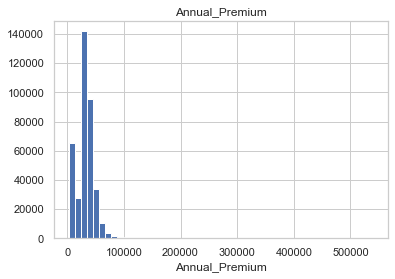

_____________________________________
count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
5%           24.000000
10%          38.000000
20%          68.000000
30%          96.000000
40%         125.000000
50%         154.000000
60%         183.000000
70%         212.000000
80%         241.000000
90%         270.000000
95%         285.000000
99%         297.000000
max         299.000000
Name: Vintage, dtype: float64


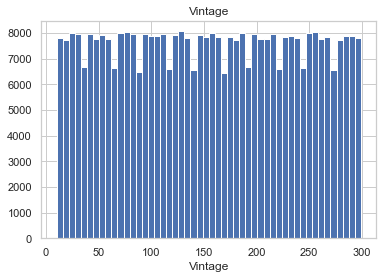

_____________________________________


In [13]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("_____________________________________")

for col in num_cols:
    num_summary(train, col, plot=True)

In [14]:
def target_summary_numerical(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col : "mean"}), end="\n\n\n")

In [15]:
for col in num_cols:
    target_summary_numerical(train, "Response", col)

                Age
Response           
0         38.178227
1         43.435560


          Region_Code
Response             
0           26.336544
1           26.762963


          Annual_Premium
Response                
0           30419.160276
1           31604.092742


             Vintage
Response            
0         154.380243
1         154.112246




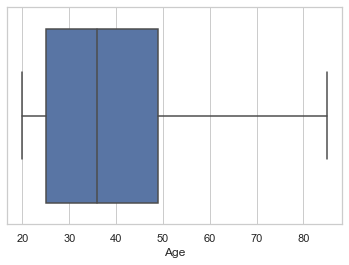

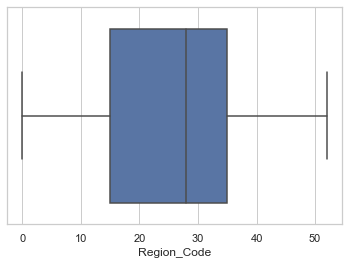

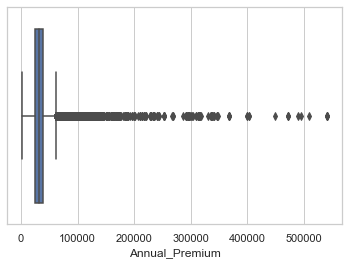

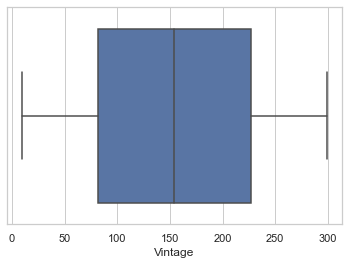

In [16]:
def num_sns(dataframe, col_name, plot=False):
    if plot:
        sns.boxplot(x=dataframe[f"{col_name}"], data=dataframe)
        
for i in num_cols:
    plt.figure(i)
    num_sns(train, i, plot=True)

### VEHICLE AGE-RESPONSE VISUALIZATION

In [17]:
df=train.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
df

,Vehicle_Age,Response,count
0,1-2 Year,0,165510
1,1-2 Year,1,34806
2,< 1 Year,0,157584
3,< 1 Year,1,7202
4,> 2 Years,0,11305
5,> 2 Years,1,4702


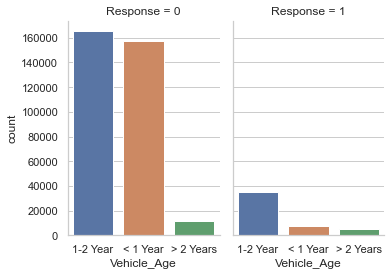

In [18]:
plot_v_age_res = sns.catplot(x="Vehicle_Age", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

### VEHICLE DAMAGE-RESPONSE VISUALIZATION

In [19]:
df=train.groupby(['Vehicle_Damage','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

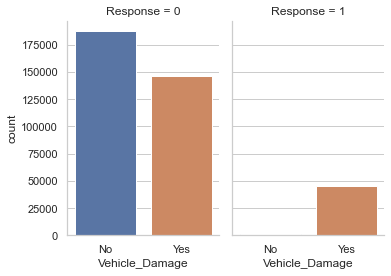

In [20]:
plot_v_res = sns.catplot(x="Vehicle_Damage", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

### AGE-ANNUAL PREMIUM VISUALIZATION

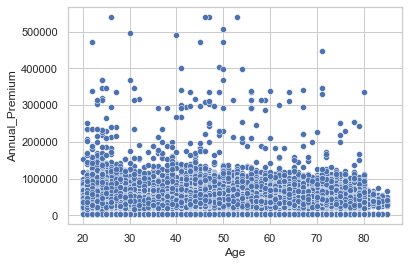

In [21]:
sns.scatterplot(x=train['Age'],y=train['Annual_Premium']);

## DATA PREPROCESSING

### FINDING OUTLIERS

In [22]:
def outlier_thresholds(df, col_name, q1=0.05, q3=0.95):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 3 * interquantile_range
    low_limit = quartile1 - 3 * interquantile_range
    return low_limit, up_limit


def check_outlier(df, col_name):
    low_limit, up_limit = outlier_thresholds(df, col_name)
    if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [23]:
for col in num_cols:
    print(f"{col} : {check_outlier(train,col)}")

Age : False
Region_Code : False
Annual_Premium : True
Vintage : False


In [24]:
def grab_outliers(df, col_name, index=False):
    low, up = outlier_thresholds(df, col_name)

    if df[((df[col_name] < low) | (df[col_name] > up))].shape[0] > 10:
        print(df[((df[col_name] < low) | (df[col_name] > up))].head())
    else:
        print(df[((df[col_name] < low) | (df[col_name] > up))])

    if index:
        outlier_index = df[((df[col_name] < low) | (df[col_name] > up))].index
        return outlier_index

In [25]:
for col in num_cols:
    col, grab_outliers(train, col)

Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []
Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []
          id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
1412    1413  Female   41                1         28.0                   0   
11319  11320  Female   50                1         46.0                   1   
13426  13427  Female   47                1         28.0                   0   
15024  15025  Female   32                1         28.0                   0   
25532  25533    Male   50                1         28.0                   0   

      Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
1412     1-2 Year            Yes        267698.0                 124.0   

In [26]:
def replace_with_thresholds(df, variable):
    low_limit, up_limit = outlier_thresholds(df, variable)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit

In [27]:
for col in num_cols:
    replace_with_thresholds(train, col)

In [28]:
# CHECK OUTLIERS AGAIN
for col in num_cols:
    print(f"{col} : {check_outlier(train,col)}")

Age : False
Region_Code : False
Annual_Premium : False
Vintage : False


In [29]:
train.drop("id",axis =1).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,0.00,0.05,0.50,0.95,0.99,1.00
Age,20.0,21.0,36.0,69.0,77.0,85.0
Driving_License,0.0,1.0,1.0,1.0,1.0,1.0
Region_Code,0.0,5.0,28.0,47.0,50.0,52.0
Previously_Insured,0.0,0.0,0.0,1.0,1.0,1.0
Annual_Premium,2630.0,2630.0,31669.0,55176.0,72963.0,212814.0
Policy_Sales_Channel,1.0,26.0,133.0,160.0,160.0,163.0
Vintage,10.0,24.0,154.0,285.0,297.0,299.0
Response,0.0,0.0,0.0,1.0,1.0,1.0


### CORRELATION ANALYSIS

,1,2,corr
0,Policy_Sales_Channel,Age,-0.890519
36,id,id,1.000000


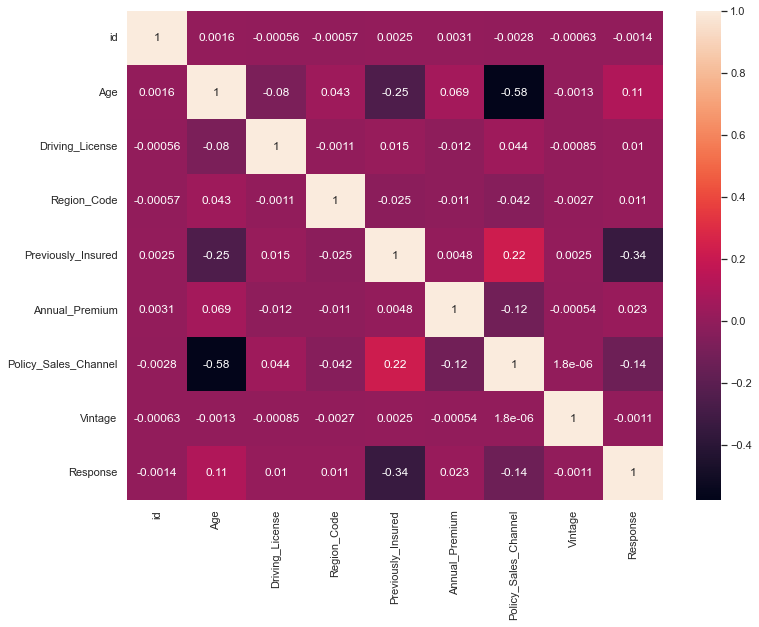

In [30]:
df.corrwith(train["Response"]).sort_values(ascending=False)
corr_df = train.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_df, annot=True, xticklabels=corr_df.columns, yticklabels=corr_df.columns)

corr_df = corr_df.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['1', '2']
corr_df = corr_df.reset_index()
corr_df.sort_values(by="corr", ascending=True).head(30)

high_corr = corr_df[(corr_df["corr"] >= 0.70) | (corr_df["corr"] <= -0.70)]
high_corr

### FEATURE ENGINEERING

#### TRAIN SET 

In [31]:
num_feat = ['Age','Vintage']
cat_feat = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes']

In [32]:
train['Gender'] = train['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

In [33]:
train=pd.get_dummies(train,drop_first=True)

In [34]:
train=train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
train['Vehicle_Age_lt_1_Year']=train['Vehicle_Age_lt_1_Year'].astype('int')
train['Vehicle_Age_gt_2_Years']=train['Vehicle_Age_gt_2_Years'].astype('int')
train['Vehicle_Damage_Yes']=train['Vehicle_Damage_Yes'].astype('int')

In [35]:
ss = StandardScaler()
train[num_feat] = ss.fit_transform(train[num_feat])

mm = MinMaxScaler()
train[['Annual_Premium']] = mm.fit_transform(train[['Annual_Premium']])

In [36]:
train = train.drop('id', axis=1)

In [37]:
for col in cat_feat:
    train[col] = train[col].astype('str') 

In [38]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes
0,1,0.333777,1,28.0,0,0.179957,26.0,0.748795,1,0,1,1
1,1,2.396751,1,3.0,0,0.147043,26.0,0.342443,0,0,0,0
2,1,0.527181,1,28.0,0,0.169680,26.0,-1.521998,1,0,1,1
3,1,-1.148985,1,11.0,1,0.123649,152.0,0.581474,0,1,0,0
4,0,-0.633242,1,41.0,1,0.118306,152.0,-1.378580,0,1,0,0


#### TEST SET

In [39]:
test['Gender'] = test['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
test=pd.get_dummies(test,drop_first=True)
test=test.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
test['Vehicle_Age_lt_1_Year']=test['Vehicle_Age_lt_1_Year'].astype('int')
test['Vehicle_Age_gt_2_Years']=test['Vehicle_Age_gt_2_Years'].astype('int')
test['Vehicle_Damage_Yes']=test['Vehicle_Damage_Yes'].astype('int')

In [40]:
test[num_feat] = ss.fit_transform(test[num_feat])

test[['Annual_Premium']] = mm.fit_transform(test[['Annual_Premium']])

In [41]:
for col in cat_feat:
    test[col] = test[col].astype('str')

#### TRAIN-TEST SPLIT

In [42]:
target = train['Response']
train = train.drop(['Response'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=0)

In [43]:
id=test.id

In [44]:
test = test.drop('id', axis=1)

In [45]:
x_train.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
       'Vehicle_Age_lt_1_Year', 'Vehicle_Age_gt_2_Years',
       'Vehicle_Damage_Yes'],
      dtype='object')

## MODEL BUILDING AND EVALUATION

In [46]:
!pip install hyperopt


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
# Import packages for model building
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint
import pickle
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score,confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 

### 1.0 RANDOM FOREST CLASSIFIER

In [48]:
x_train.dtypes

Gender                     object
Age                       float64
Driving_License            object
Region_Code               float64
Previously_Insured         object
Annual_Premium            float64
Policy_Sales_Channel      float64
Vintage                   float64
Vehicle_Age_lt_1_Year      object
Vehicle_Age_gt_2_Years     object
Vehicle_Damage_Yes         object
dtype: object

In [49]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2,3,4,5,6,7,10],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [300]}

clf = RandomForestClassifier()
rf_model = RandomizedSearchCV(estimator = clf, 
                           param_distributions = random_search, 
                           n_iter = 10,
                           cv = 4, 
                           verbose= 1, 
                           random_state= 42, 
                           n_jobs = -1)
rf_model.fit(x_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 10],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [300]},
                   random_state=42, verbose=1)

#### 1.1 SAVING THE TRAINED MODEL

In [50]:
filename = 'RF_MODEL.sav'
pickle.dump(rf_model, open(filename, 'wb'))

In [51]:
filename = 'RF_MODEL.sav'

In [52]:
rf_load = pickle.load(open(filename, 'rb'))

#### 1.2 MODEL EVALUATION

In [53]:
y_pred_rf = rf_model.predict(x_test)

In [54]:
predictions_rf = [round(value) for value in y_pred_rf]
accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Random Forest Accuracy: %.2f%%" % (accuracy_rf * 100.0))

Random Forest Accuracy: 87.70%


#### 1.3 CLASSIFICATION REPORT

In [56]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66846
           1       0.56      0.00      0.00      9376

    accuracy                           0.88     76222
   macro avg       0.72      0.50      0.47     76222
weighted avg       0.84      0.88      0.82     76222



#### 1.4 ROC CURVE & AUC OF RANDOM FOREST CLASSIFIER

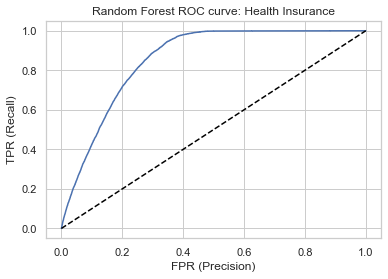

Area under curve (AUC): 0.8550950723590232


In [57]:
y_score = rf_model.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.title('Random Forest ROC curve: Health Insurance')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0, 1), ls='dashed', color='black')
plt.show()
print('Area under curve (AUC):', auc(fpr, tpr))

In [58]:
roc_auc_score(y_test, y_score)

0.8550950723590232

### 2.0 XGBOOST CLASSIFIER

In [59]:
for column in cat_feat:
    x_train[column] = x_train[column].astype('int')
    x_test[column] = x_test[column].astype('int')

In [60]:
space={ 'max_depth': hp.quniform("max_depth", 3,18,1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 300,
        'seed': 0
      }

In [61]:
def model_processing(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(x_test)
    y_score = clf.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test, pred>0.5)
    Roc_Auc_Score = roc_auc_score(y_test, y_score)
    print ("ROC-AUC Score:",Roc_Auc_Score)
    print ("SCORE:", accuracy)
    return {'loss': -Roc_Auc_Score, 'status': STATUS_OK }

In [62]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [63]:
trials = Trials()

In [64]:
best_hyperparams = fmin(fn = model_processing,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

ROC-AUC Score:                                                                                                         
0.8520981482167916                                                                                                     
SCORE:                                                                                                                 
0.8769646558736323                                                                                                     
ROC-AUC Score:                                                                                                         
0.8534323788356589                                                                                                     
SCORE:                                                                                                                 
0.8769908950171866                                                                                                     
ROC-AUC Score:                          

ROC-AUC Score:                                                                                                         
0.8546334818063811                                                                                                     
SCORE:                                                                                                                 
0.8769908950171866                                                                                                     
ROC-AUC Score:                                                                                                         
0.8541057314995016                                                                                                     
SCORE:                                                                                                                 
0.8769908950171866                                                                                                     
ROC-AUC Score:                          

In [65]:
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

The best hyperparameters are:  

{'colsample_bytree': 0.72006649063841, 'gamma': 1.532956578917811, 'max_depth': 17.0, 'min_child_weight': 5.0, 'reg_alpha': 51.0, 'reg_lambda': 0.6207289119757194}


Using the best hyperparameters to build the final model:

In [66]:
xgb_model=xgb.XGBClassifier(n_estimators = space['n_estimators'], 
                            max_depth = 17, 
                            gamma =1.532956578917811, 
                            reg_lambda = 0.6207289119757194,
                            reg_alpha = 51.0, 
                            min_child_weight=5.0,
                            colsample_bytree = 0.72006649063841)

In [67]:
xgb_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.72006649063841, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=1.532956578917811, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=17, max_leaves=0,
              min_child_weight=5.0, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=51.0, reg_lambda=0.6207289119757194, ...)

#### 2.1 SAVING THE TRAINED MODEL

In [68]:
filename = 'XGBOOST_MODEL.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

#### 2.2 MAKING PREDICTIONS

In [69]:
y_pred_xgb = xgb_model.predict(x_test)

In [70]:
predictions_xgb = [round(value) for value in y_pred_xgb]
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
print("XGBOOST Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

XGBOOST Accuracy: 87.71%


#### 2.3 CLASSIFICATION REPORT

In [72]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66846
           1       0.52      0.02      0.03      9376

    accuracy                           0.88     76222
   macro avg       0.70      0.51      0.48     76222
weighted avg       0.83      0.88      0.82     76222



#### 2.4 ROC CURVE & AUC OF XGBOOST CLASSIFIER

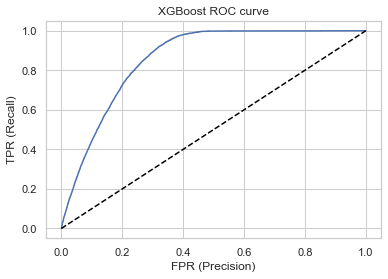

Area under curve (AUC):  0.8584966726408692


In [73]:
y_score = xgb_model.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.title('XGBoost ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

### 3.0 LGBM 

In [74]:
random_state = 42
n_iter = 50
num_folds = 2
kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

In [75]:
def lgbm_mse_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
    # The functions get a set of variable parameters in "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'learning_rate': params['learning_rate'],
              'gamma': params['gamma'],
              'reg_alpha' : params['reg_alpha'],
              'reg_lambda' : params['reg_lambda'],
              'colsample_bytree' : params['colsample_bytree'],
              'min_child_weight' : params['min_child_weight']
             }
    
    # we use this params to create a new LGBM Regressor
    model = lgb.LGBMClassifier(random_state=42, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

    return score

In [76]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 2, 8, 1),
       'learning_rate': hp.loguniform("learning_rate",-4,-1),
        'gamma': hp.quniform('gamma',0.1,0.5,0.1),
        'reg_alpha' : hp.quniform('reg_alpha',1.1,1.5,0.1),
        'reg_lambda' : hp.uniform('reg_lambda',1.1,1.5),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,0.5),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=lgbm_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
#           rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

# computing the score on the test set
lgbm_model = lgb.LGBMClassifier(random_state=random_state, n_estimators=int(best['n_estimators']),
                           max_depth=int(best['max_depth']),learning_rate=best['learning_rate'],gamma=best['gamma'],
                           reg_alpha=best['reg_alpha'],reg_lambda=best['reg_lambda'],colsample_bytree=best['colsample_bytree'],
                           min_child_weight=best['min_child_weight'])
lgbm_model.fit(x_train,y_train)

preds = [pred[1] for pred in lgbm_model.predict_proba(x_test)]
score = roc_auc_score(y_test, preds, average = 'weighted')

100%|████████████████████████████████████████████████| 50/50 [06:48<00:00,  8.17s/trial, best loss: -0.857181681347539]
[LightGBM] [Warning] Unknown parameter: gamma


In [77]:
best

{'colsample_bytree': 0.45504673085537795,
 'gamma': 0.1,
 'learning_rate': 0.0719253651085137,
 'max_depth': 5.0,
 'min_child_weight': 7.0,
 'n_estimators': 193.0,
 'reg_alpha': 1.5,
 'reg_lambda': 1.1451509646136793}

In [78]:
print("auc-roc score on Test data",score)

auc-roc score on Test data 0.8590493596010861


#### 3.1 SAVING THE TRAINED MODEL

In [79]:
filename = 'LGBM_MODEL.sav'
pickle.dump(lgbm_model, open(filename, 'wb'))

#### 3.2 MAKING PREDICTIONS

In [80]:
y_pred_lgbm = lgbm_model.predict(x_test)

In [81]:
predictions_lgbm = [round(value) for value in y_pred_lgbm]
accuracy_lgbm = accuracy_score(y_test, predictions_lgbm)
print("LGBM Accuracy: %.2f%%" % (accuracy_lgbm * 100.0))

LGBM Accuracy: 87.71%


#### 3.3 CLASSIFICATION REPORT

In [83]:
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66846
           1       0.55      0.01      0.01      9376

    accuracy                           0.88     76222
   macro avg       0.71      0.50      0.47     76222
weighted avg       0.84      0.88      0.82     76222



#### 3.4 ROC CURVE & AUC OF LGBM CLASSIFIER

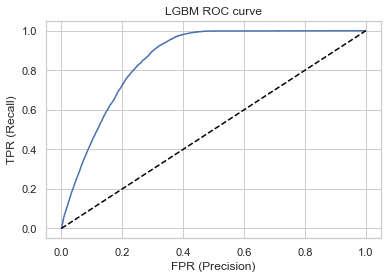

Area under curve (AUC):  0.8590493596010861


In [84]:
y_score = lgbm_model.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.title('LGBM ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

### 4.0 CATBOOST

In [85]:
cat_model = CatBoostClassifier()
cat_model = cat_model.fit(x_train, y_train, cat_features = cat_feat, eval_set = (x_test, y_test), early_stopping_rounds = 10, verbose = 100)

predictions = [pred[1] for pred in cat_model.predict_proba(x_test)]
print('Validation ROC AUC Score:', roc_auc_score(y_test, predictions, average = 'weighted'))

Learning rate set to 0.130164
0:	learn: 0.4910079	test: 0.4911860	best: 0.4911860 (0)	total: 285ms	remaining: 4m 44s
100:	learn: 0.2635035	test: 0.2650177	best: 0.2650177 (100)	total: 6.85s	remaining: 1m
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.2645406725
bestIteration = 178

Shrink model to first 179 iterations.
Validation ROC AUC Score: 0.8587709391302244


#### 4.1 SAVING THE TRAINED MODEL

In [86]:
filename = 'CATBOOST_MODEL.sav'
pickle.dump(cat_model, open(filename, 'wb'))

#### 4.2 MAKING PREDICTIONS

In [87]:
y_pred_cat = cat_model.predict(x_test)

In [88]:
predictions_cat = [round(value) for value in y_pred_cat]
accuracy_cat = accuracy_score(y_test, predictions_cat)
print("CATBOOST Accuracy: %.2f%%" % (accuracy_cat * 100.0))

CATBOOST Accuracy: 87.70%


#### 4.3 CLASSIFICATION REPORT

In [90]:
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66846
           1       0.49      0.01      0.02      9376

    accuracy                           0.88     76222
   macro avg       0.69      0.50      0.48     76222
weighted avg       0.83      0.88      0.82     76222



#### 4.4 ROC AND AUC OF CATBOOST CLASSIFIER

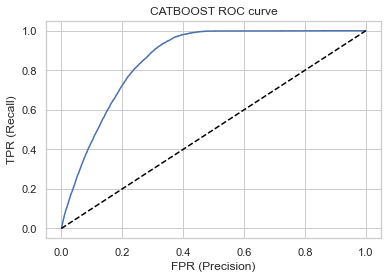

Area under curve (AUC):  0.8587709391302244


In [91]:
y_score = cat_model.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.title('CATBOOST ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

## RESULT COMPARISON

After building various different models and finding out the best possible hyperparameters to train them in order to best fit each model to our dataset, we have finally obtained the accuracy scores of each of these models.

In [109]:
results_dict = {
    'Random Forest': accuracy_rf,
    'XGBOOST': accuracy_xgb,
    'LGBM': accuracy_lgbm,
    'CATBOOST': accuracy_cat
}
results_df = pd.DataFrame(results_dict.items(), columns=['Model', 'Accuracy Score']).set_index('Model').sort_values(by="Accuracy Score", ascending=False)
results_df

,Accuracy Score
Model,
XGBOOST,0.877122
LGBM,0.877122
Random Forest,0.877004
CATBOOST,0.876965


The performance of all the models used in this project is more or less same but XGBOOST and LGBM models have performed the best amongst all.